<a href="https://colab.research.google.com/github/himanshud2611/BuildingFromScratch/blob/main/transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setting up pytorch
!pip3 install torch torchvision torchaudio

In [2]:
# importing libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [3]:
# multihead self attention mechanism
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention -> parallel computation
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

the MultiHeadAttention class encapsulates the multi-head attention mechanism commonly used in transformer models. It takes care of splitting the input into multiple attention heads, applying attention to each head, and then combining the results. By doing so, the model can capture various relationships in the input data at different scales, improving the expressive ability of the model.

In [4]:
# position-wise FFNN
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff) # fully connected layer
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

the PositionWiseFeedForward class defines a position-wise feed-forward neural network that consists of two linear layers with a ReLU activation function in between. In the context of transformer models, this feed-forward network is applied to each position separately and identically. It helps in transforming the features learned by the attention mechanisms within the transformer, acting as an additional processing step for the attention outputs.

In [5]:
# positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

the PositionalEncoding class adds information about the position of tokens within the sequence. Since the transformer model lacks inherent knowledge of the order of tokens (due to its self-attention mechanism), this class helps the model to consider the position of tokens in the sequence. The sinusoidal functions used are chosen to allow the model to easily learn to attend to relative positions, as they produce a unique and smooth encoding for each position in the sequence.

In [6]:
# building the encoder blocks
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

the EncoderLayer class defines a single layer of the transformer's encoder. It encapsulates a multi-head self-attention mechanism followed by position-wise feed-forward neural network, with residual connections, layer normalization, and dropout applied as appropriate. These components together allow the encoder to capture complex relationships in the input data and transform them into a useful representation for downstream tasks. Typically, multiple such encoder layers are stacked to form the complete encoder part of a transformer model.

In [7]:
# building the decoder block
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

the DecoderLayer class defines a single layer of the transformer's decoder. It consists of a multi-head self-attention mechanism, a multi-head cross-attention mechanism (that attends to the encoder's output), a position-wise feed-forward neural network, and the corresponding residual connections, layer normalization, and dropout layers. This combination enables the decoder to generate meaningful outputs based on the encoder's representations, taking into account both the target sequence and the source sequence. As with the encoder, multiple decoder layers are typically stacked to form the complete decoder part of a transformer model.

Next, the Encoder and Decoder blocks are brought together to construct the comprehensive Transformer model.

combining encoder and decoder layers to complete the transformer network

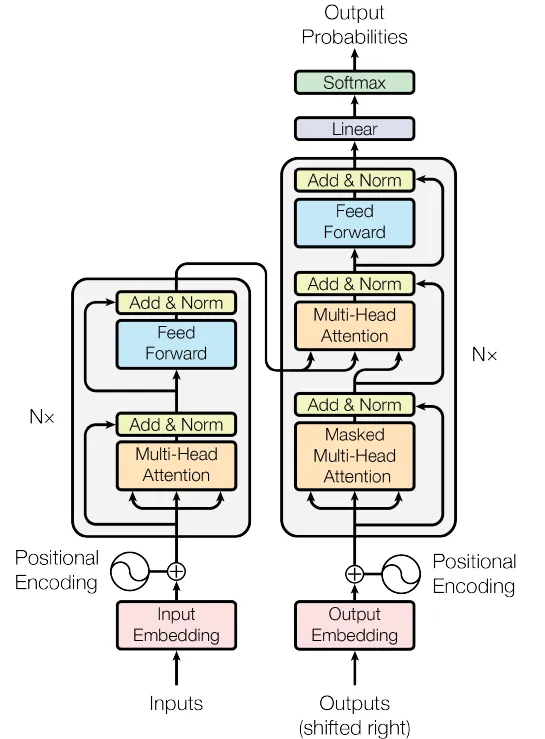

In [8]:
# complete transformer network
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

the Transformer class brings together the various components of a Transformer model, including the embeddings, positional encoding, encoder layers, and decoder layers. It provides a convenient interface for training and inference, encapsulating the complexities of multi-head attention, feed-forward networks, and layer normalization.

This implementation follows the standard Transformer architecture, making it suitable for sequence-to-sequence tasks like machine translation, text summarization, etc. The inclusion of masking ensures that the model adheres to the causal dependencies within sequences, ignoring padding tokens and preventing information leakage from future tokens.

These sequential steps empower the Transformer model to efficiently process input sequences and produce corresponding output sequences.

## Training the Transformer Model

In [9]:
# sample data preparation
src_vocab_size = 5000 # vocabulary size for source sequence
tgt_vocab_size = 5000 # vocabulary size for target sequence
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048 # dimensionality of inner layer in FFNN
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
# (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))
# (batch_size, seq_length)

this demonstrates how to initialize a transformer model and generate random source and target sequences that can be fed into the model. The chosen hyperparameters determine the specific structure and properties of the transformer. This setup could be part of a larger script where the model is trained and evaluated on actual sequence-to-sequence tasks, such as machine translation or text summarization.

In [11]:
# training the model
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(45):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1]) # Passes the source data and the target data (excluding the last token in each sequence) through the transformer.
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.69861888885498
Epoch: 2, Loss: 8.55380630493164
Epoch: 3, Loss: 8.482980728149414
Epoch: 4, Loss: 8.425860404968262
Epoch: 5, Loss: 8.372029304504395
Epoch: 6, Loss: 8.30845832824707
Epoch: 7, Loss: 8.22864055633545
Epoch: 8, Loss: 8.14760684967041
Epoch: 9, Loss: 8.07029914855957
Epoch: 10, Loss: 7.989805221557617
Epoch: 11, Loss: 7.91111946105957
Epoch: 12, Loss: 7.833140850067139
Epoch: 13, Loss: 7.7476806640625
Epoch: 14, Loss: 7.665003776550293
Epoch: 15, Loss: 7.578267574310303
Epoch: 16, Loss: 7.500191688537598
Epoch: 17, Loss: 7.418069362640381
Epoch: 18, Loss: 7.336943626403809
Epoch: 19, Loss: 7.249477386474609
Epoch: 20, Loss: 7.173128604888916
Epoch: 21, Loss: 7.089629650115967
Epoch: 22, Loss: 7.0107197761535645
Epoch: 23, Loss: 6.935414791107178
Epoch: 24, Loss: 6.85722017288208
Epoch: 25, Loss: 6.780589580535889
Epoch: 26, Loss: 6.704692363739014
Epoch: 27, Loss: 6.629848480224609
Epoch: 28, Loss: 6.566921234130859
Epoch: 29, Loss: 6.49520206451416
Epoc

this trains the transformer model on randomly generated source and target sequences for 100 epochs. It uses the Adam optimizer and the cross-entropy loss function. The loss is printed for each epoch, allowing monitor the training progress. In a real-world scenario, we'll replace the random source and target sequences with actual data from your task, such as machine translation.

In [12]:
# performance evaluation
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.716486930847168


this evaluates the transformer model on a randomly generated validation dataset, computes the validation loss, and prints it. In a real-world scenario, the random validation data should be replaced with actual validation data from the task you are working on. The validation loss can give an indication of how well model is performing on unseen data, which is a critical measure of the model's generalization ability.